### Use Python LightGBM and Optuna hyper parameter tuning to build model and deploy with KNIME Python nodes


<img src="../KNIME_loves_lightgbm_optuna.png" width="600">


##### KNIME workflows for Binary Classifications
https://hub.knime.com/-/spaces/-/~GABT_OgeoWxWJW9P/current-state/

https://hub.knime.com/-/spaces/-/~0dXvsD0vMrv_w6Fw/current-state/


##### MEDIUM Blog: Hyperparameter optimization for LightGBM — wrapped in KNIME nodes

https://medium.com/p/ddb7ae1d7e2

###### Optuna

https://optuna.readthedocs.io/en/stable/index.html

###### additional links and texts

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy

https://stackoverflow.com/questions/67080149/xgboost-error-when-categorical-type-is-supplied-dmatrix-parameter-enable-cat


https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997

https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5


https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

some parameters have been discussed with ChatGPT ....

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import json
import pickle
import logging

In [2]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation, record_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, average_precision_score, precision_recall_curve

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import matplotlib.pyplot as plt
import plotly
import matplotlib
import kaleido

/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 9.0.0. Please consider upgrading.
  warnings.warn(


In [3]:
# http://strftime.org'
import time
var_timestamp_day = "{}".format(time.strftime("%Y%m%d"))
# flow_variables['var_timestamp_day'] = var_timestamp_day
print("var_timestamp_day: ", var_timestamp_day)

var_timestamp_time = "{}h".format(time.strftime("%H%M"))
# flow_variables['var_timestamp_time'] = var_timestamp_time
print("var_timestamp_time: ", var_timestamp_time)

# _edit: if you want to have another model name
var_model_name = "LightGBM_Optuna_Classification"
# flow_variables['var_model_name'] = var_model_name

var_model_name_full = var_model_name + "_" + var_timestamp_day  + "_" + var_timestamp_time + "_jupyter"
# flow_variables['var_model_name_full'] = var_model_name_full
print("var_model_name_full: ", var_model_name_full)

# if you dp not want to store the files in the working directory
var_path_data = "../result/"
var_path_model = "../model/"

var_timestamp_day:  20240229
var_timestamp_time:  1525h
var_model_name_full:  LightGBM_Optuna_Classification_20240229_1525h_jupyter


In [4]:
data      = pq.read_table("../train.parquet").to_pandas()
data_test = pq.read_table("../test.parquet").to_pandas()

In [5]:
data = data.reset_index(drop=True)

In [6]:
data_test = data_test.reset_index(drop=True)

In [7]:
excluded_features = ['row_id']
label = ['Target']
# features = [feat for feat in data.columns if feat not in excluded_features and not feat==label]
features = [feat for feat in data.columns if feat not in excluded_features and feat not in label]

num_cols = data[features].select_dtypes(include='number').columns.tolist()
cat_cols = data[features].select_dtypes(exclude='number').columns.tolist()

rest_cols = [feat for feat in data.columns if feat not in cat_cols]

print(f'''{"data shape:":20} {data.shape}
{"data[features] shape:":20} {data[features].shape}
categorical columns: {cat_cols}
numerical columns: {num_cols}
feature columns: {features}
rest columns: {rest_cols}''')

# THX David Gutmann 

data shape:          (34189, 16)
data[features] shape: (34189, 14)
categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
feature columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
rest columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'Target', 'row_id']


In [8]:
print(data.dtypes)

age                int32
workclass         object
fnlwgt             int32
education         object
education-num      int32
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int32
capital-loss       int32
hours-per-week     int32
native-country    object
Target            object
row_id            object
dtype: object


In [9]:
data[cat_cols] = data[cat_cols].astype('category')

In [10]:
data[label] = data[label].astype('int32')

### Normalize by Log(), Decimal or Robust Scaling - optional treatment of data

#### or use vtreat ....

In [11]:
# Define the number of decimal places for the scaling
decimal_places_n = 2

In [12]:
def decimal_scaling(input_df, cols_to_normalize, decimal_places):
    """
    Apply decimal scaling to the selected columns in the input dataframe and return a new dataframe with the scaled values.
    
    Parameters:
    input_df (pandas.DataFrame): The input dataframe to be scaled.
    cols_to_normalize (list): A list of column names to be scaled.
    decimal_places (int): The number of decimal places to scale the values.
    
    Returns:
    pandas.DataFrame: A new dataframe with the scaled values.
    """
    output_df = input_df.copy()
    for col in cols_to_normalize:
        max_value = input_df[col].max()
        min_value = input_df[col][input_df[col] > 0].min()
        scaling_factor = 10 ** (len(str(int(max_value))) - decimal_places)
        output_df[col] = input_df[col].apply(lambda x: (x - min_value) / scaling_factor)
    return output_df


In [13]:
# Apply decimal scaling to the input dataframe and store the result in the output dataframe
data_normalized = decimal_scaling(input_df=data, cols_to_normalize=num_cols, decimal_places=decimal_places_n)

In [14]:
data_normalized.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Target,row_id
0,22.0,State-gov,0.63747,Bachelors,12.0,Never-married,Adm-clerical,Not-in-family,White,Male,2.060,-1.55,39.0,United-States,0,Row0
1,21.0,Private,2.01877,HS-grad,8.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,-0.114,-1.55,39.0,United-States,0,Row1
2,36.0,Private,2.20952,11th,6.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,-0.114,-1.55,39.0,United-States,0,Row2
3,20.0,Private,2.70813,Masters,13.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,-0.114,-1.55,39.0,United-States,0,Row3
4,32.0,Private,1.46418,9th,4.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,-0.114,-1.55,15.0,Jamaica,0,Row4


In [15]:
from sklearn.preprocessing import MinMaxScaler

def log_scaling(input_df, cols_to_transform, cols_to_normalize, decimal_places=2):
    """
    Apply log transformation and Min-Max scaling to the selected columns in the input dataframe and return a new dataframe with the transformed and normalized values.
    
    Parameters:
    input_df (pandas.DataFrame): The input dataframe to be transformed and scaled.
    cols_to_transform (list): A list of column names to be transformed with log.
    cols_to_normalize (list): A list of column names to be normalized.
    decimal_places (int, optional): The number of decimal places to scale the values. Default is 2.
    
    Returns:
    pandas.DataFrame: A new dataframe with the transformed and normalized values.
    """
    output_df = input_df.copy()
    for col in cols_to_transform:
        if output_df[col].min() <= 0:
            min_value = output_df[col][output_df[col] > 0].min()
            output_df[col] = output_df[col].apply(lambda x: np.log(x - min_value + 1))
        else:
            output_df[col] = output_df[col].apply(lambda x: np.log(x))
    scaler = MinMaxScaler(feature_range=(0, 100))
    output_df[cols_to_normalize] = scaler.fit_transform(output_df[cols_to_normalize]).round(decimal_places)
    return output_df

In [16]:
data_normalized = log_scaling(input_df=data, cols_to_transform=num_cols, cols_to_normalize=num_cols)

In [17]:
data_normalized.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Target,row_id
0,49.82,State-gov,36.89,Bachelors,92.51,Never-married,Adm-clerical,Not-in-family,White,Male,66.29,NaN,80.28,United-States,0,Row0
1,48.26,Private,58.73,HS-grad,79.25,Divorced,Handlers-cleaners,Not-in-family,White,Male,NaN,NaN,80.28,United-States,0,Row1
2,68.23,Private,60.54,11th,70.18,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,NaN,NaN,80.28,United-States,0,Row2
3,46.66,Private,64.65,Masters,95.18,Married-civ-spouse,Exec-managerial,Wife,White,Female,NaN,NaN,80.28,United-States,0,Row3
4,63.52,Private,52.39,9th,58.05,Married-spouse-absent,Other-service,Not-in-family,Black,Female,NaN,NaN,60.34,Jamaica,0,Row4


In [18]:
from sklearn.preprocessing import RobustScaler

def robust_scaling(input_df, cols_to_scale, quantile_range=(25.0, 75.0)):
    """
    Apply robust scaling to the selected columns in the input dataframe and return a new dataframe with the scaled values.
    
    Parameters:
    input_df (pandas.DataFrame): The input dataframe to be scaled.
    cols_to_scale (list): A list of column names to be scaled.
    quantile_range (tuple, optional): The quantile range used to compute the scale. Default is (25.0, 75.0).
    
    Returns:
    pandas.DataFrame: A new dataframe with the scaled values.
    """
    output_df = input_df.copy()
    scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=quantile_range)
    output_df[cols_to_scale] = scaler.fit_transform(input_df[cols_to_scale])
    return output_df

In [19]:
# Apply robust scaling to the selected columns
data_normalized = robust_scaling(input_df=data, cols_to_scale=num_cols)

In [20]:
data_normalized.head(50)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Target,row_id
0,0.10,State-gov,-0.839671,Bachelors,1.000000,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,0.0,United-States,0,Row0
1,0.05,Private,0.310425,HS-grad,-0.333333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,0.0,United-States,0,Row1
2,0.80,Private,0.469247,11th,-1.000000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,0.0,United-States,0,Row2
3,0.00,Private,0.884399,Masters,1.333333,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,0.0,United-States,0,Row3
4,0.60,Private,-0.151337,9th,-1.666667,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,-4.8,Jamaica,0,Row4
5,0.75,Self-emp-not-inc,0.260435,HS-grad,-0.333333,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,1.0,United-States,1,Row5
6,-0.30,Private,-1.103902,Masters,1.333333,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,2.0,United-States,1,Row6
7,0.25,Private,-0.157481,Bachelors,1.000000,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,0.0,United-States,1,Row7
8,-0.35,State-gov,-0.308618,Bachelors,1.000000,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0.0,0.0,0.0,India,1,Row8
9,-0.70,Private,-0.467024,Bachelors,1.000000,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,-2.0,United-States,0,Row9


In [22]:
print(data_normalized.dtypes)

age                float64
workclass         category
fnlwgt             float64
education         category
education-num      float64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country    category
Target               int32
row_id              object
dtype: object


In [23]:
# split training data into X and y
X = data[features]
y = data[label]

In [24]:
# split training data into X and y
X = data[features]
y = data[label]

In [25]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
3,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
4,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica


In [26]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [27]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [28]:
 # Convert data into LightGBM dataset format
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

callbacks = [early_stopping(stopping_rounds=50, eval_metric="aucpr", first_metric_only=True),
             log_evaluation(log_filename=None, period=100, show_stdv=True)]

model = lgb.train(params, lgb_train, valid_sets=[lgb_val], callbacks=callbacks, num_boost_round=var_n_boost_round)


In [29]:
# number of iterations
var_n_boost_round = 200
    
def objective(trial):
    params = {
        'objective': 'binary',  # The task is binary classification.
        'metric': 'aucpr',  # The evaluation metric is AUCPR.
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000, step=100),  # The number of boosting rounds.
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),  # The type of boosting algorithm.
        # 'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),  # The class weight balance.
        # 'importance_type': trial.suggest_categorical('importance_type', ['split', 'gain']),  # The type of feature importance metric.
        'num_leaves': trial.suggest_int('num_leaves', 25, 500),  # The maximum number of leaves in one tree.
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),  # The learning rate of the boosting process.
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),  # The fraction of features to be randomly sampled for each tree.
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),  # The fraction of data to be randomly sampled for each tree.
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),  # The frequency of bagging.
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),  # L1 regularization term on weights.
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),  # L2 regularization term on weights.
        # 'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
        # 'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        # You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
        # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 500), # The minimum number of samples required to be at a leaf node.
        'max_depth': trial.suggest_int('max_depth', 6, 16),  # The maximum depth of a tree.
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 1.0),  # The minimum gain to split a leaf node.
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),  # The fraction of data to be used for each tree.
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),  # The fraction of features to be used for each tree.
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),  # L1 regularization term on leaf weights.
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),  # L2 regularization term on leaf weights.
        # 'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),  # Whether to balance the positive and negative weights.
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),  # The ratio of the sum of the weights of the negative class samples to the positive class samples.
        'seed': 42,  # The random seed.
        'n_jobs': -1  # Number of CPU threads to use for parallel execution, -1 means use all available CPU threads
    }
 
    # You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
        
    # Train the LightGBM model - this does work
    # model = lgb.train(params, lgb_train, num_boost_round=var_n_boost_round, valid_sets=[lgb_val])
    model = lgb.train(params, lgb_train, valid_sets=[lgb_val])
    # ----------------------------------
    
    # Evaluate the LightGBM model on the (internal) validation set
    y_pred = model.predict(X_test)
    aucpr = average_precision_score(y_test, y_pred)
    return aucpr

In [ ]:
from optuna.logging import set_verbosity

# Set the logging level to WARNING
set_verbosity(optuna.logging.ERROR)

var_n_trials = var_n_boost_round

study = optuna.create_study(direction="maximize")
# https://optuna.readthedocs.io/en/stable/reference/logging.html
optuna.logging.set_verbosity(optuna.logging.ERROR)
study.optimize(objective, n_trials=var_n_trials)


print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
   

In [31]:
best_trial = study.best_trial
best_params = best_trial.params

# Set up the logger to write to a file
logger = logging.getLogger()
handler = logging.FileHandler(var_path_model + var_model_name_full + "_best_parameters_apply.log")
logger.addHandler(handler)

# Train the LightGBM model using the best hyperparameters
# best_model = lgb.train(best_params, lgb_train, num_boost_round=var_n_boost_round, valid_sets=[lgb_val])
best_model = lgb.train(best_params, lgb_train, valid_sets=[lgb_val])

# Reverse the logging to the file on disc
logger.removeHandler(handler)
handler.close() 

/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=8.184901624940332, reg_alpha=1.3983412166553182 will be ignored. Current value: lambda_l1=8.184901624940332
[LightGBM] [Warning] feature_fraction is set=0.45406721511235004, colsample_bytree=0.853845209498792 will be ignored. Current value: feature_fraction=0.45406721511235004
[LightGBM] [Warning] lambda_l2 is set=7.010791900836442, reg_lambda=2.618389420783807 will be ignored. Current value: lambda_l2=7.010791900836442
[LightGBM] [Warning] bagging_fraction is set=0.7011558893118903, subsample=0.6422286634795097 will be ignored. Current value: bagging_fraction=0.7011558893118903
[LightGBM] [Warning] lambda_l1 is set=4.073023218904668, reg_alpha=9.475559679609987 will be ignored. Current value: lambda_l1=4.073023218904668
[LightGBM] [Warning] feature_fraction is set=0.44974806560917313, colsample_bytree=0.5143518926777751 will be ignored. Current value: feature_fraction=0.44974806560917313
[LightGBM] [Warning] lambda_l2 is set=0.730209393543246, reg

In [32]:
# show the best parameters
print(best_model.params)

{'boosting_type': 'dart', 'num_leaves': 195, 'learning_rate': 0.1001805010056419, 'feature_fraction': 0.44974806560917313, 'bagging_fraction': 0.9764278880927072, 'bagging_freq': 9, 'lambda_l1': 4.073023218904668, 'lambda_l2': 0.730209393543246, 'max_depth': 13, 'min_gain_to_split': 0.9182409030885195, 'subsample': 0.741583309590573, 'colsample_bytree': 0.5143518926777751, 'reg_alpha': 9.475559679609987, 'reg_lambda': 6.645592152809871, 'scale_pos_weight': 1.8894680998172, 'objective': None, 'num_iterations': 900, 'categorical_column': [1, 3, 5, 6, 7, 8, 9, 13]}


In [33]:
# evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# evaluate the initial values based on the (internal Test data)
auc_pred = roc_auc_score(y_test, y_pred, average='weighted')
print(f'Test AUC: {auc_pred:.4f}')

aucpr = average_precision_score(y_test, y_pred, average='weighted', pos_label=1)
print(f'Test AUCPR: {aucpr:.4f}')


Test AUC: 0.9261
Test AUCPR: 0.8251


In [34]:
import pickle
# set the path for the pickel file
path_model = var_path_model + var_model_name_full + "_model_stored.pkl"
# Save object as pickle file
pickle.dump(best_model, open(path_model, 'wb'), pickle.HIGHEST_PROTOCOL)

In [35]:
# Get the feature importance
importance = best_model.feature_importance()

# Store the feature importance and column names in a Pandas DataFrame
feature_imp = pd.DataFrame({"Feature": X_test.columns, "Value": importance})
feature_imp = feature_imp.sort_values(by='Value', ascending=False, na_position='last')

feature_imp = feature_imp.reset_index(drop=True)
feature_imp['Feature_Rank'] = feature_imp.index

In [36]:
feature_imp.head(25)

,Feature,Value,Feature_Rank
0,capital-gain,945,0
1,capital-loss,815,1
2,age,800,2
3,hours-per-week,680,3
4,occupation,597,4
5,education-num,561,5
6,education,455,6
7,relationship,331,7
8,marital-status,295,8
9,workclass,264,9


In [37]:
feature_imp.to_parquet(var_path_model + var_model_name_full + "_feature_importance.parquet", compression='gzip')

In [38]:
type(y_pred)

numpy.ndarray

In [39]:
# store the variales list as dictionary in a JSON file to read back later

v_variable_list = {
    "var_model_name": var_model_name,
    "var_model_name_full": var_model_name_full,
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "rest_cols": rest_cols,
    "label": label,
    "features": features,
    "excluded_features": excluded_features,
    "Test_AUC": f'{auc_pred:.5f}',
    "Test_AUCPR": f'{aucpr:.5f}'
}

In [40]:
print(v_variable_list)

{'var_model_name': 'LightGBM_Optuna_Classification', 'var_model_name_full': 'LightGBM_Optuna_Classification_20240229_1525h_jupyter', 'num_cols': ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'], 'cat_cols': ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'], 'rest_cols': ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'Target', 'row_id'], 'label': ['Target'], 'features': ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], 'excluded_features': ['row_id'], 'Test_AUC': '0.92613', 'Test_AUCPR': '0.82512'}


In [41]:
type(v_variable_list)

dict

In [42]:
# Write the dictionary to a JSON file
with open(var_path_model + var_model_name_full + "_variable_list.json", "w") as f:
    json.dump(v_variable_list, f)

In [43]:
# show the best parameters
best_parameters = best_model.params
print(best_parameters)

{'boosting_type': 'dart', 'num_leaves': 195, 'learning_rate': 0.1001805010056419, 'feature_fraction': 0.44974806560917313, 'bagging_fraction': 0.9764278880927072, 'bagging_freq': 9, 'lambda_l1': 4.073023218904668, 'lambda_l2': 0.730209393543246, 'max_depth': 13, 'min_gain_to_split': 0.9182409030885195, 'subsample': 0.741583309590573, 'colsample_bytree': 0.5143518926777751, 'reg_alpha': 9.475559679609987, 'reg_lambda': 6.645592152809871, 'scale_pos_weight': 1.8894680998172, 'objective': None, 'num_iterations': 900, 'categorical_column': [1, 3, 5, 6, 7, 8, 9, 13]}


In [44]:
with open(var_path_model + var_model_name_full + "_model_parameters.txt", "w") as file:
    print(best_parameters, file=file)

In [45]:
df_best_parameters = pd.read_csv(var_path_model + var_model_name_full + "_model_parameters.txt", sep = "@",header = None, names=["lgbm_parameters"])

In [46]:
df_best_parameters.head()

,lgbm_parameters
0,"{'boosting_type': 'dart', 'num_leaves': 195, '..."


In [47]:
# Path for Image
var_path_opt_history_png = var_path_model + var_model_name_full + "_opt_history.png"

# Plot the optimization history and save to a file
fig = plot_optimization_history(study)
fig.write_image(var_path_opt_history_png)    

# Plot the hyperparameter importances - this pictures might get large so maybe look at them in the PNG file
# plot_optimization_history(study)

In [48]:
# Path for Image
var_path_param_importances_png = var_path_model + var_model_name_full + "_param_importances.png"

# Plot the hyperparameter importances and save to a file
fig_para = plot_param_importances(study)
fig_para.write_image(var_path_param_importances_png)

# Plot the hyperparameter importances - this pictures might get large so maybe look at them in the PNG file
# plot_param_importances(study)

## Apply the LightGBM model with all the settings

In [49]:
import pickle
# set the path for the pickel file
path_apply_model = var_path_model + var_model_name_full + "_model_stored.pkl"

clf_apply = pickle.load(open(path_apply_model, 'rb'))

In [50]:
import json

# Read the JSON file back into a Python dictionary
with open(var_path_model + var_model_name_full + "_variable_list.json", "r") as f:
    loaded_dict = json.load(f)

# fill the list of categorical columns
new_cat_cols = loaded_dict['cat_cols']
new_features = loaded_dict['features']

In [51]:
print(new_cat_cols)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [52]:
df_test_apply = data_test[new_features].copy()
df_test_apply[new_cat_cols] = df_test_apply[new_cat_cols].astype('category')

In [53]:
# Get the predicted probabilities for each class
probabilities = clf_apply.predict(df_test_apply)
# prediction = clf_apply.predict(df_test_apply)

In [54]:
probabilities_df = pd.DataFrame(probabilities, columns = ['P1'])
# prediction_df = pd.DataFrame(prediction, columns = ['Target_pred'])

In [55]:
probabilities_df.head()

,P1
0,0.454732
1,0.489419
2,0.535538
3,0.135268
4,-0.009678


In [56]:
# Join the original target column with the predicted probabilities
result = pd.concat([data_test, probabilities_df], axis=1)

In [57]:
result.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Target,row_id,P1
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,Row0,0.454732
1,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,Row1,0.489419
2,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,1,Row2,0.535538
3,32,Private,205019,Assoc-acdm,12,Never-married,Sales,Not-in-family,Black,Male,0,0,50,United-States,0,Row3,0.135268
4,25,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,35,United-States,0,Row4,-0.009678


In [58]:
result.to_parquet(var_path_data + var_model_name_full + "_scored_test_data.parquet", compression='gzip')

In [59]:
# evaluate the best model on the test data
auc_pred = roc_auc_score(result['Target'], result['P1'], average='weighted')
print(f'Test AUC: {auc_pred:.4f}')

Test AUC: 0.9247


In [60]:
# from sklearn.metrics import average_precision_score
aucpr = average_precision_score(result['Target'], result['P1'], average='weighted', pos_label='1')
print(f'Test AUCPR: {aucpr:.4f}')

Test AUCPR: 0.8207


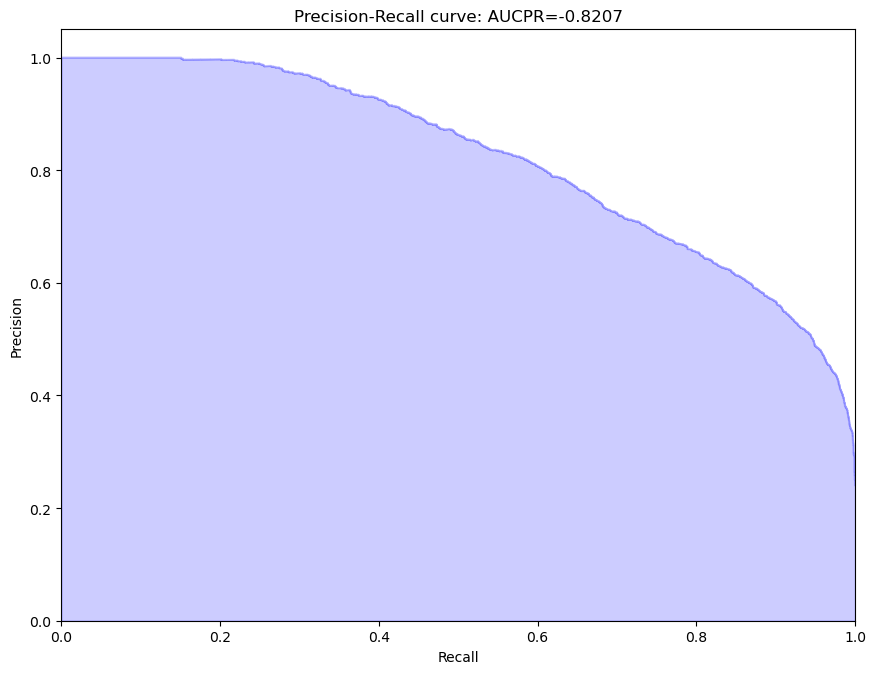

In [61]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_true = result["Target"].astype(int).values
y_score = result["P1"].values

precision, recall, thresholds = precision_recall_curve(y_true, y_score)
auc_pr = np.trapz(precision, recall)

plt.tight_layout()
plt.gcf().set_size_inches(10.24, 7.68)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUCPR={0:0.4f}'.format(auc_pr))
plt.show()

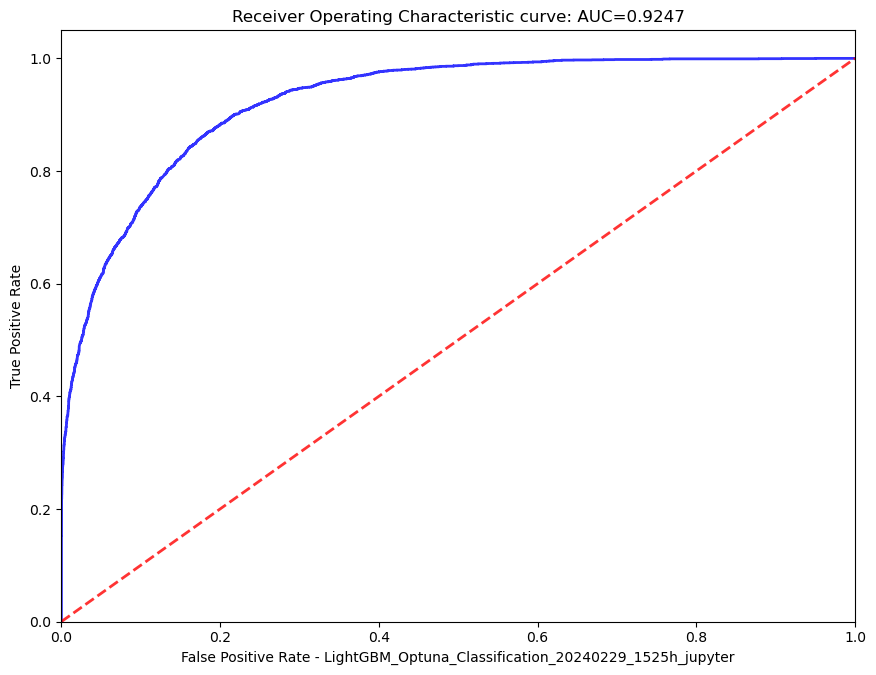

In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true = result["Target"].astype(int).values
y_score = result["P1"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_roc = auc(fpr, tpr)

plt.tight_layout()
plt.gcf().set_size_inches(10.24, 7.68)
plt.plot(fpr, tpr, color='b', lw=2, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
plt.xlabel('False Positive Rate - ' + var_model_name_full)
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Receiver Operating Characteristic curve: AUC={0:0.4f}'.format(auc_roc))
plt.savefig(var_path_model + var_model_name_full + "_auc_plot.png")
plt.show()